# MIDAS Code Example


This Jupyter notebook is a quick interactive example of how to use MIDAS in practice. To this end, I will quickly reproduce the method by which we attained estimated variance of imputed values on the [Adult Census dataset](https://archive.ics.uci.edu/ml/datasets/adult).

Code right now is very hot. If you have any problems getting this demo running, it may just be I've respecified default parameters.

For now, setup must be done manually. Later versions will include pip support. Copy both midas.py and adult_data.csv into your Jupyter Notebooks directory. This is so they can be read into memory. The first thing we will do is manage imports, and import the data we will be using.  

In [2]:
from midas import Midas
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd

data_0 = pd.read_csv('adult_data.csv').drop(['Unnamed: 0', 'class_labels'], axis=1)
print(data_0.head())

   age         workclass  fnlwgt  education  education_num  \
0   39         State-gov   77516  Bachelors             13   
1   50  Self-emp-not-inc   83311  Bachelors             13   
2   38           Private  215646    HS-grad              9   
3   53           Private  234721       11th              7   
4   28           Private  338409  Bachelors             13   

       marital_status         occupation   relationship   race     sex  \
0       Never-married       Adm-clerical  Not-in-family  White    Male   
1  Married-civ-spouse    Exec-managerial        Husband  White    Male   
2            Divorced  Handlers-cleaners  Not-in-family  White    Male   
3  Married-civ-spouse  Handlers-cleaners        Husband  Black    Male   
4  Married-civ-spouse     Prof-specialty           Wife  Black  Female   

   capital_gain  capital_loss  hours_per_week native_country  
0          2174             0              40  United-States  
1             0             0              13  United-St

Next, we will generate some missingness. Very few columns in the actual data contain missing values, so we want to change this. For the variance tests, we spiked in 100 values to test against. For this example, let's make this number a little larger - 5000 values in each column. We will then replace the sampled indices with np.nan...our missing value. While it is possible to sample 5000 values directly, we often used masks as they allow us to return later and inspect the error. While this notebook won't be reproducing that process, feel free to adapt the code examples. We also save one of the removed values for the end.

In [3]:
np.random.seed(441)

def spike_in_generation(data):
    spike_in = pd.DataFrame(np.zeros_like(data), columns= data.columns)
    for column in data.columns:
        subset = np.random.choice(data[column].index[data[column].notnull()],
                                     5000, replace= False)
        spike_in.loc[subset, column] = 1
    return spike_in

spike_in = spike_in_generation(data_0)
original_value = data_0.loc[4, 'hours_per_week']
data_0[spike_in == 1] = np.nan

The next task is to code the categorical variables. This is done by subsetting them out to a new dataframe, and converting them to One-Hot. We need to ensure that missing values aren't converted to zeroes yet, so we generate a temporary index to mark the location of missing entries. Finally, the encoded categorical columns are appended to a list already containing data_0 - the continuous variables. 

The utility of columns_list may not be apparent now, but it simplifies things immensely when it comes to building the MIDAS instance. If your data contains a lot of categorical data that needs conversion to One-Hot, consider implementing something similar.

In [4]:
categorical = ['workclass','education','marital_status','occupation',
               'relationship','race','sex','native_country']
data_0.columns.str.strip()
data_1 = data_0[categorical]
data_0.drop(categorical, axis= 1, inplace= True)

constructor_list = [data_0]
columns_list = []

for column in data_1.columns:
    na_temp = data_1[column].isnull()
    temp = pd.get_dummies(data_1[column])
    temp[na_temp] = np.nan
    constructor_list.append(temp)
    columns_list.append(list(temp.columns.values))

Next, we concat the dataset back into one dataframe, and apply a minmax scaler. Minmax maps the range of all values to between 0 and 1 - useful for keeping the gradients flowing through the neural network small. Smaller numbers means weight updates will have gradual change, not destructive oscillation. In some cases, having the minimum value equal to 0 does have some drawbacks, though. If your low-end values are giving you strange results, consider trying a different scaling scheme.

We used the minmax scaler on the entire dataset for convenience. Minmax won't affect OneHot variables, but other scalers might. Again, we marked the locations of the np.nan values, and were sure to replace them once we'd scaled the columns. Numpy, SkLearn and Tensorflow don't share R's 'na.rm' functionality. Instead, we have to be sure to pass in numeric values or else we'll have errors returned.

In [5]:
data_0 = pd.concat(constructor_list, axis=1)

scaler = MinMaxScaler()
na_loc = data_0.isnull()
data_0.fillna(data_0.median(), inplace= True)
data_0 = pd.DataFrame(scaler.fit_transform(data_0), columns= data_0.columns)
data_0[na_loc] = np.nan

Finally, with the data prepared, we can use MIDAS to impute the missing vlaues. The first thing we will do is instantiate MIDAS. For this test, we will build a small 3 layer network for demonstration. [NOTE: the notation used here is a little strange for the moment. Experiments in adding an explicitly variational generative component have led to some hack-y workarounds on the backend.] All the hyperparameters are specified in the instantiation, and all the data is passed into the .build_model() method. As the categories we are using are mutually exclusive, we must pass these column names into the softmax_columns argument. This ensures we have error accurately measured for each category, and the loss is appropriately weighted.

In general, bigger models are better. The 'magic' of stochastic regularisation means it's generally better to have excess capacity as opposed to not enough. Feel free to experiment with larger and smaller models, but remember...bigger models can take much longer to train!

In [6]:
imputer = Midas([128, 128], vae_layer= False, seed= 42)
imputer.build_model(data_0, softmax_columns= columns_list)

Size index: [6, 8, 16, 7, 14, 6, 5, 2, 41]


C:\Users\Alex\Anaconda3\envs\tensorflow-gpu\lib\site-packages\tensorflow\python\ops\gradients_impl.py:96: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "



Computation graph constructed



There are a number of additional arguments that can be passed to both the instantiation and most methods. To check what they are and recommended settings, consult the [list of MIDAS functions](https://github.com/Oracen/MIDAS/blob/master/midas_functions.md). Alternatively, just use the ?? command on any method to display the help text. Using the help command on the class itself will bring up the entire source code, so if you're not used to coding in Python, the commands you're looking for are found under "init". 

In [ ]:
??Midas.generate_samples()

In [ ]:
??Midas

First, we want to make sure our model is building an accurate representation of the data. The first method we should call is .overimpute(). This method removes a set proportion of known values, and allows us to explore the evolution of the model's output. It is a way of estimating the ideal model complexity which will give us the most accurate imputations - the values become our out-of-sample data. We do not want to do this during the actual run, though. Not only does a train-test split setup overestimate ideal model complexity in autoencoders, but it denies the model anywhere between 10% and 30% of existing data. At higher levels of missingness, this additional data could be crucial.

In general, we want to see both cost and out-of-sample error constantly decreasing. In practice, too much capacity and too much training may cause error to rise again. This is called overtraining, and it is to be avoided. If clear overtraining appears while running .overimpute(), ensure that the 'training_epochs' argument of .train_model() is set to end training before this point.


Model initialised

Epoch: 0 , loss: 9.1826792332
Individual RMSE on spike-in: 0.157678026391
Aggregated RMSE on spike-in: 0.1407241118
Individual error on softmax spike-in: 0.38610717096
Aggregated error on softmax spike-in: 0.354567593571


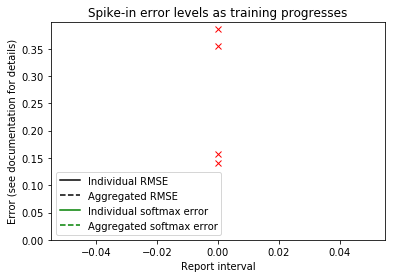

Epoch: 1 , loss: 5.37132584775
Epoch: 2 , loss: 4.45884144587
Epoch: 3 , loss: 4.03810544033
Epoch: 4 , loss: 3.79113225809
Epoch: 5 , loss: 3.64695520888
Epoch: 6 , loss: 3.55544362988
Epoch: 7 , loss: 3.47306762153
Epoch: 8 , loss: 3.43813465096
Epoch: 9 , loss: 3.36811396866
Epoch: 10 , loss: 3.3401091041
Individual RMSE on spike-in: 0.139996165988
Aggregated RMSE on spike-in: 0.135615623187
Individual error on softmax spike-in: 0.387935283308
Aggregated error on softmax spike-in: 0.335651697658


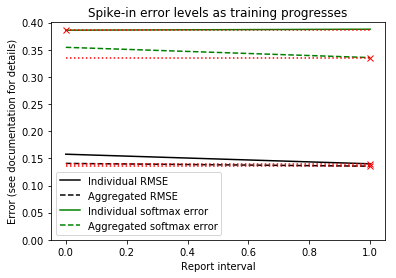

Epoch: 11 , loss: 3.31171676231
Epoch: 12 , loss: 3.27980174872
Epoch: 13 , loss: 3.25407384205
Epoch: 14 , loss: 3.23191642835
Epoch: 15 , loss: 3.19557750983
Epoch: 16 , loss: 3.18657983174
Epoch: 17 , loss: 3.19181498967
Epoch: 18 , loss: 3.15371763261
Epoch: 19 , loss: 3.14907021162
Epoch: 20 , loss: 3.12132332827
Individual RMSE on spike-in: 0.13973070823
Aggregated RMSE on spike-in: 0.135327916871
Individual error on softmax spike-in: 0.384420061426
Aggregated error on softmax spike-in: 0.332518371441


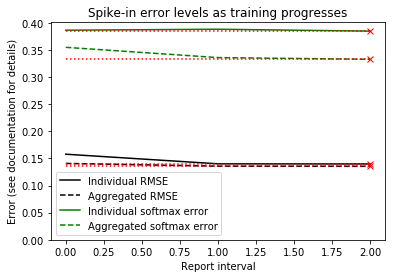

Epoch: 21 , loss: 3.11584981124
Epoch: 22 , loss: 3.0832133797
Epoch: 23 , loss: 3.07540077032
Epoch: 24 , loss: 3.07296724561
Epoch: 25 , loss: 3.08338881648
Epoch: 26 , loss: 3.03650497027
Epoch: 27 , loss: 3.02634476756
Epoch: 28 , loss: 3.02349731334
Epoch: 29 , loss: 3.00738947076
Epoch: 30 , loss: 2.99088254216
Individual RMSE on spike-in: 0.139798282862
Aggregated RMSE on spike-in: 0.134960208408
Individual error on softmax spike-in: 0.380060770086
Aggregated error on softmax spike-in: 0.329462678417


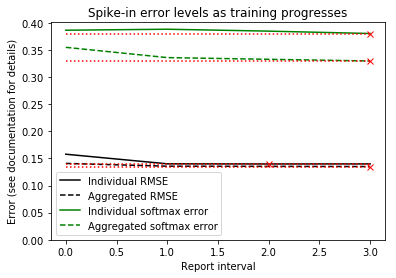

Overimputation complete. Adjust complexity as needed.


In [7]:
imputer.overimpute(training_epochs= 30, report_samples= 5, plot_all= False)

30 epochs seemed to be a reasonable number. In reality, had we run the algorithm longer, we probably would have attained better results. In fact, in practice we want to run overimputation for as long as time will allow, to ensure we are getting the most accurate possible results. Still, 30 epochs will will serve for the purposes of this demo.

We run the .train_model() method, with printouts every 5 epochs to ensure training is progressing as expected.

In [8]:
imputer.train_model(training_epochs= 30, verbosity_ival= 5)

Model initialised

Epoch: 0 , loss: 9.18345088634
Epoch: 5 , loss: 3.71117453717
Epoch: 10 , loss: 3.36884722446
Epoch: 15 , loss: 3.24351734689
Epoch: 20 , loss: 3.13509029115
Epoch: 25 , loss: 3.06289620727
Training complete. Saving file...
Model saved in file: tmp/MIDAS


Now the model is trained, we can use the saved model to generate as many imputations as we need. We generate 20 samples, which will be saved to the .output_list attribute. We then recall the value we saved right at the very start of the demo, and from each dataset extract the value for the same observation as well as its mean. Of course, now that the model is saved, we don't need to retrain the model should we return to this result.

In [9]:
imputer.batch_generate_samples(m= 5)

print("Original value:", original_value)
imputed_vals = []
for dataset in imputer.output_list:
    imputed_vals.append(pd.DataFrame(scaler.inverse_transform(dataset),
                                     columns= dataset.columns).iloc[50, 0])
print("Imputed values:")
print(imputed_vals)
print("Imputation mean:", np.mean(imputed_vals))
print("Standard deviation of the imputation mean:", np.std(imputed_vals))

INFO:tensorflow:Restoring parameters from tmp/MIDAS
Model restored.
Original value: 40
Imputed values:
[30.297980591654778, 33.828222885727882, 35.228299781680107, 33.074873194098473, 29.665981993079185]
Imputation mean: 32.4190716892
Standard deviation of the imputation mean: 2.11594307594


Code-wise, that's it! You may notice the imputation mean is not perfectly accurate, with a low variance. This is a known limitation of variational inference methods, and we're currently working on implementing solutions that will improve the match between true and estimated data. In general; MIDAS currently underestimates the marginal posterior density. Unfortunately, this flows out of the maths of KL(Q||P) underlying Gal's Bayesian interpretation of dropout. That being the case, methods for improving variational estimates are constantly improving.

This short demonstration has illustrated the main steps in using MIDAS. I hope it helps you with your own missing data challenges.